<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Handling-3D-Inputs-with-PICASO" data-toc-modified-id="Handling-3D-Inputs-with-PICASO-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Handling 3D Inputs with PICASO</a></span><ul class="toc-item"><li><span><a href="#xarray-tutorial:-Convert-numpy-arrays-to--xarray-DataSet" data-toc-modified-id="xarray-tutorial:-Convert-numpy-arrays-to--xarray-DataSet-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><code>xarray</code> tutorial: Convert <code>numpy</code> arrays to  <code>xarray</code> DataSet</a></span></li><li><span><a href="#xarray-tutorial:-Easy-plotting" data-toc-modified-id="xarray-tutorial:-Easy-plotting-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span><code>xarray</code> tutorial: Easy plotting</a></span></li><li><span><a href="#xesfm-tutorial:-Step-by-step-regrid-3D-GCM" data-toc-modified-id="xesfm-tutorial:-Step-by-step-regrid-3D-GCM-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span><code>xesfm</code> tutorial: Step-by-step regrid 3D GCM</a></span></li><li><span><a href="#Regrid-3D-GCM-with-PICASO" data-toc-modified-id="Regrid-3D-GCM-with-PICASO-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Regrid 3D GCM with PICASO</a></span></li></ul></li></ul></div>

# Handling 3D Inputs with PICASO

Many GCM groups have their files stored as `netCDF` files. Therefore, you may already be used to `xarray` format. If that is the case you will be able to directly input your xarray formatted data to `PICASO` to get out post-processed spectra. If not though, this tutorial will walk you through how to structure your data in xarray format.

What you will learn:

1. How to convert traditional numpy arrays to `xarray` formatted data, which is common for 3D GCM output
2. How to regrid using `xarray` and `xesmf`'s `regridder`
3. How to use `PICASO` built in function (which use #2)



In [1]:
import pandas as pd
import numpy as np

from picaso import justdoit as jdi

Two new packages you will need, that are not required components of other models: xesmf and xarray. You can read more about the installing these packages here:

[Install XESMF](https://xesmf.readthedocs.io/en/latest/installation.html)
- will only be needed if you want to use their really handy regridding tools

[Install xarray](http://xarray.pydata.org/en/stable/getting-started-guide/installing.html)
- needed for all `PICASO` 3d operations

In [2]:
import xesmf as xe
import xarray as xr

We will begin with an example file from the MIT GCM group (courtesy of Tiffany Kataria).

In [3]:
gcm_out =  jdi.HJ_pt_3d()

We are going to go through the motions of converting basic `numpy` arrays to `xarray` format. **If you already understand xarrays you may skip to** the [`picaso` section](#regrid-3d-gcm-with-picaso)

In [4]:
gcm_out.keys()

dict_keys(['pressure', 'temperature', 'kzz', 'latitude', 'longitude'])

In this example, pressure, temperature, and kzz are all on a coordinate system that is :

n_longitude (128) x n_latitude (64) x n_pressure (53)


In [5]:
gcm_out['temperature'].shape, len(gcm_out['longitude']), len(gcm_out['latitude'])

((128, 64, 53), 128, 64)

## `xarray` tutorial: Convert `numpy` arrays to  `xarray` DataSet

The comments with `required` next to them indicate that they are required for `picaso` to create a spectrum

In [6]:
# create data
data = gcm_out['temperature']

# create coords
lon = gcm_out['longitude']
lat = gcm_out['latitude']
pres = gcm_out['pressure'][0,0,:]

# put data into a dataset
ds = xr.Dataset(
    data_vars=dict(
        temperature=(["lon", "lat","pressure"], data,{'units': 'Kelvin'})#, required
        #kzz = (["x", "y","z"], gcm_out['kzz'])#could add other data components if wanted
    ),
    coords=dict(
        lon=(["lon"], lon,{'units': 'degrees'}),#required
        lat=(["lat"], lat,{'units': 'degrees'}),#required
        pressure=(["pressure"], pres,{'units': 'bar'})#required*
    ),
    attrs=dict(description="coords with vectors"),
)

In [7]:
ds

<xarray.Dataset> Size: 3MB
Dimensions:      (lon: 128, lat: 64, pressure: 53)
Coordinates:
  * lon          (lon) float64 1kB -180.0 -177.2 -174.4 ... 171.6 174.4 177.2
  * lat          (lat) float64 512B -90.0 -87.19 -84.38 ... 81.56 84.38 87.19
  * pressure     (pressure) float64 424B 170.6 120.5 ... 3.42e-06 2.416e-06
Data variables:
    temperature  (lon, lat, pressure) float64 3MB 1.896e+03 1.809e+03 ... 750.7
Attributes:
    description:  coords with vectors

##  `xarray` tutorial: Easy plotting

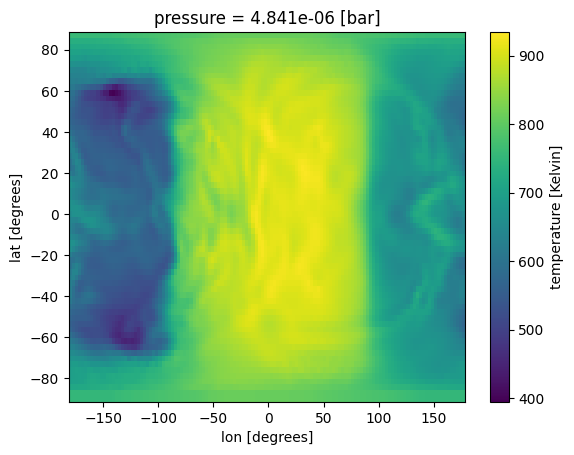

In [8]:
ds['temperature'].isel(pressure=50).plot(x='lon',y='lat')

## `xesmf` tutorial: Step-by-step regrid 3D GCM

The biggest complication with moving to 3D is making sure that the latitude/longitude grids of some users GCM and `picaso` line up properly. `picaso` computes a flux integration on specific `gauss` and `tchebychev` angles. **Meaning, your GCM input will need to be regridded to fit our angles.** Luckily, as you will see below, it is very easy to do this!

First, we will show you how this is done using `xesmf`, then we will introduce the `PICASO` function that leverages these same techniques.

### Step 1) Get latitude/longitude grid used by `picaso`

**G**auss angles are essentially equivalent to lon**G**itudes

**T**chebychev angles are essentially equivalent to la**T**itudes.

In [9]:
n_gauss_angles =10
n_chebychev_angles=10

gangle, gweight, tangle, tweight = jdi.get_angles_3d(n_gauss_angles, n_chebychev_angles)
ubar0, ubar1, cos_theta, latitude, longitude = jdi.compute_disco(n_gauss_angles, n_chebychev_angles, gangle, tangle, phase_angle=0)

### Step 2) Create the `xesmf` regridder

In [10]:
ds_out = xr.Dataset({'lon': (['lon'], longitude*180/np.pi),
                     'lat': (['lat'], latitude*180/np.pi),
                    }
                   )

regridder = xe.Regridder(ds, ds_out, 'bilinear')
ds_out = regridder(ds,keep_attrs=True)

/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


All done!

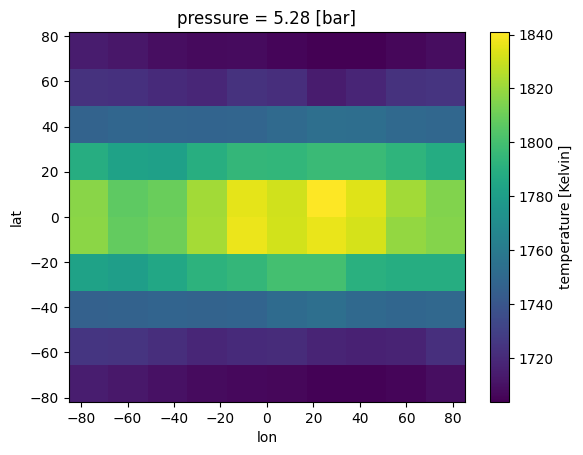

In [11]:
ds_out['temperature'].isel(pressure=10).plot(x='lon', y ='lat')

## Regrid 3D GCM with PICASO

The above code is all the PICASO built in function does -- in addition to completing some checks to make sure that your model run is on the same grid as what you are wanting PICASO run.

In [12]:
ds =  jdi.HJ_pt_3d(as_xarray=True)

### DIY Option 1

For completeness, first here is the function `picaso` uses internally. You might use this if you want to manipulate results before supplying `picaso` with your final input.

verbose=True;Only one data variable included. Make sure to add in chemical abundances before trying to run spectra.


/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


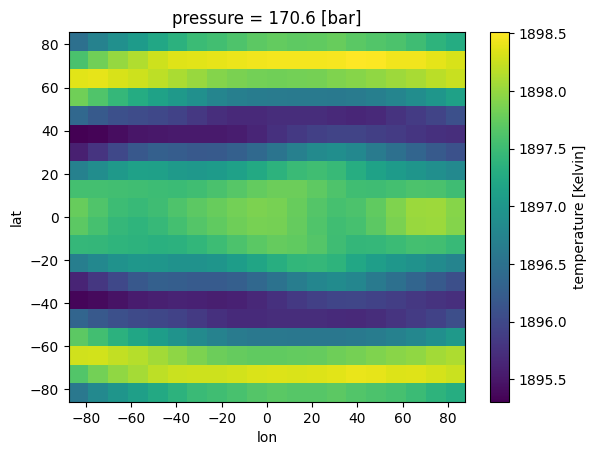

In [13]:
#regrid yourself
out_ds = jdi.regrid_xarray(ds, num_gangle=20,
                               num_tangle=20, phase_angle=0)
#then supply to picaso
case_3d = jdi.inputs()
case_3d.phase_angle(0, num_gangle=20, num_tangle=20)

#here, regrid is false because you have already done it yourself
case_3d.atmosphere_3d(out_ds,regrid=False,plot=True,verbose=True)

### Easiest Option 2

Use the regular `PICASO` workflow to regrid your 3d input

verbose=True;regrid=True; Regridding 3D output to ngangle=20, ntangle=20, with phase=0.


verbose=True;Only one data variable included. Make sure to add in chemical abundances before trying to run spectra.


/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


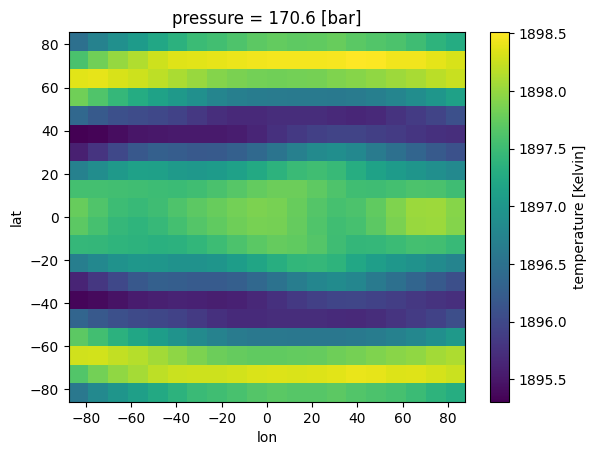

In [14]:
case_3d = jdi.inputs()
case_3d.phase_angle(0, num_gangle=20, num_tangle=20)
#regrid is True as you will do it within the function
case_3d.atmosphere_3d(ds,regrid=True,plot=True,verbose=True)

We have solved regridding our temperature-pressure profile. However, PICASO has notified us of another step we must take before running a spectrum: *verbose=True;Only one data variable included. Make sure to add in chemical abundances before trying to run spectra.*

In the next notebook you will see how to add chemistry and/or clouds to your 3D input.